##### Verifica se as condições climáticas altera o preço da cenoura e prediz o seu preço

Tem-se verificado um constante aumento de preços da cenoura no varejo, para o consumidor final.

Segundo o G1 o calor foi o responsável pela redução da produção de cenouras.

https://g1.globo.com/economia/agronegocios/noticia/2024/03/12/por-que-os-precos-da-cenoura-batata-e-cebola-estao-nas-alturas.ghtml

Segundo o site HF Brasil as chuvas impediram a colheita com maquinário atrasando o plantio das safras seguintes.

https://www.hfbrasil.org.br/br/hortifruti-cepea-efeitos-do-el-nio-no-desenvolvimento-das-hortalicas-no-verao-2023-24.aspx 

Neste estudo, através de dados do clima, o objetivo é confirmar se as condições climáticas estão prejudicando
a safra de cenouras e qual seria o preço desse legume.

Escolheu-se os dados da região de São Gotardo - MG que é responsável pela maior parte da produção de cenouras
do Brasil, distribuindo para a região e Triângulo Mineiro.

Os dados climáticos são da região de São Gotardo - MG e os dados de preços do produtor são do Triângulo Mineiro.

https://www.hfbrasil.org.br/br/banco-de-dados-precos-medios-dos-hortifruticolas.aspx

https://portal.inmet.gov.br/dadoshistoricos

In [1]:
# importa bibliotecas
import pandas as pd
from pandasql import sqldf
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# carrega arquivo de cotações de cenoura
cenoura = pd.read_excel('arquivos/cepea_cenoura_2021-2024.xlsx')

In [3]:
# carrega arquivos de variáveis climáticas da região de São Gotardo, responsável pela oferta no Triângulo Mineiro
clima1 = pd.read_csv('arquivos/inmet_araxa_2021.csv', sep=';', encoding='latin-1')
clima2 = pd.read_csv('arquivos/inmet_araxa_2022.csv', sep=';', encoding='latin-1')
clima3 = pd.read_csv('arquivos/inmet_araxa_2023.csv', sep=';', encoding='latin-1')
clima4 = pd.read_csv('arquivos/inmet_araxa_2024.csv', sep=';', encoding='latin-1')

### Reconhecimento e tratamento dos dados do preço de cenoura

In [4]:
# verifica quantas linhas e quantas colunas tem no data frame de cotações de preço
cenoura.shape

(695, 8)

In [5]:
# analisa as primeiras linhas
# colunas de Produto, Região, data separada em Dia, Mês e Ano, Unidade de peso e Preço da cotação
cenoura.head(3)

,Produto,Região,Dia,Mês,Ano,Moeda,Unidade kg,Preço
0,Verao A lavada - beneficiador,Triangulo Mineiro/Alto Paranaiba,29,2,2024,R$,20,50.0
1,Verao AAA lavada - beneficiador,Triangulo Mineiro/Alto Paranaiba,29,2,2024,R$,20,117.5
2,Verao G lavada - beneficiador,Triangulo Mineiro/Alto Paranaiba,29,2,2024,R$,20,95.0


In [6]:
# verifica se os tipos de variáveis estão coerentes e se tem algum dado nulo
# Não existe nenhum dado nulo, todos os valores de non-null é o mesmo do total de linhas do df
cenoura.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Produto     695 non-null    object 
 1   Região      695 non-null    object 
 2   Dia         695 non-null    int64  
 3   Mês         695 non-null    int64  
 4   Ano         695 non-null    int64  
 5   Moeda       695 non-null    object 
 6   Unidade kg  695 non-null    int64  
 7   Preço       695 non-null    float64
dtypes: float64(1), int64(4), object(3)
memory usage: 43.6+ KB


In [7]:
# verifica se tem algum produto (forma comercial de cenoura) com nome duplicado
cenoura.groupby('Produto').count()

,Região,Dia,Mês,Ano,Moeda,Unidade kg,Preço
Produto,,,,,,,
Inverno A lavada - beneficiador,76,76,76,76,76,76,76
Inverno A lavada - atacado,1,1,1,1,1,1,1
Inverno AAA lavada - atacado,1,1,1,1,1,1,1
Inverno AAA lavada - beneficiador,74,74,74,74,74,74,74
Inverno G lavada - atacado,4,4,4,4,4,4,4
Inverno G lavada - beneficiador,74,74,74,74,74,74,74
Inverno suja - produtor,74,74,74,74,74,74,74
Verao A lavada - beneficiador,96,96,96,96,96,96,96
Verao AAA - atacado,2,2,2,2,2,2,2


In [8]:
# cria coluna de preço por kg para colocar todos os preços na mesma unidade de medida (kg)
cenoura['Preço_kg'] = round(cenoura['Preço']/cenoura['Unidade kg'], 2)

In [9]:
# cria coluna de anomesdia para fazer o join com os dados de clima
cenoura['ano_mes_dia'] = (((cenoura.Ano * 100) + cenoura['Mês']) * 100) + cenoura.Dia

In [10]:
# separa somente as colunas que serão utilizadas
cenoura = cenoura[['Produto', 'Preço_kg', 'ano_mes_dia']]

In [11]:
# verifica se as linhas e colunas estão ok
cenoura.head(3)

,Produto,Preço_kg,ano_mes_dia
0,Verao A lavada - beneficiador,2.50,20240229
1,Verao AAA lavada - beneficiador,5.88,20240229
2,Verao G lavada - beneficiador,4.75,20240229


### Reconhecimento e tratamento dos dados de clima da região produtora

In [12]:
# junta todas as linhas dos dfs clima em um dataframe apenas
clima = pd.concat([clima1, clima2, clima3, clima4], ignore_index=True)

In [13]:
# verifica se todas as linhas foram concatenadas
print('clima1', clima1.shape)
print('clima2', clima2.shape)
print('clima3', clima3.shape)
print('clima4', clima4.shape)

total_linhas = (clima1.shape[0]) + (clima2.shape[0]) + (clima3.shape[0]) + (clima4.shape[0])

print('total linhas      ', clima.shape[0])
print('total linhas soma ', total_linhas)

clima1 (8760, 20)
clima2 (8760, 20)
clima3 (8760, 20)
clima4 (1440, 19)
total linhas       27720
total linhas soma  27720


In [14]:
# faz um reconhecimento inicial do df clima
clima.head(3)

,Data,Hora UTC,PRECIPITAÇÃO TOTAL. HORÁRIO (mm),PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO. HORARIA (mB),PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),TEMPERATURA DO AR - BULBO SECO. HORARIA (°C),TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),UMIDADE RELATIVA DO AR. HORARIA (%),VENTO. DIREÇÃO HORARIA (gr) (° (gr)),VENTO. RAJADA MAXIMA (m/s),VENTO. VELOCIDADE HORARIA (m/s),Unnamed: 19
0,2021/01/01,0000 UTC,0.0,902.2,902.2,901.4,2018.6,24.0,17.5,24.2,23.9,18.1,17.3,70.0,66.0,67.0,87.0,3.9,1.7,NaN
1,2021/01/01,0100 UTC,0.0,902.6,902.6,902.1,2021.4,22.5,17.7,24.0,22.2,17.7,17.4,75.0,67.0,74.0,166.0,4.1,0.5,NaN
2,2021/01/01,0200 UTC,0.0,902.8,902.8,902.6,2024.4,22.9,17.4,23.0,22.1,17.7,17.2,75.0,70.0,71.0,16.0,2.3,0.6,NaN


In [15]:
# vamos pegar somente as colunas que serão utilizadas, a hora será preservada para a checagem de
# linhas duplicadas e para ordenar as linhas por data e hora
clima = clima[['Data', 'Hora UTC', 'PRECIPITAÇÃO TOTAL. HORÁRIO (mm)', 'TEMPERATURA DO AR - BULBO SECO. HORARIA (°C)',
               'TEMPERATURA DO PONTO DE ORVALHO (°C)', 'UMIDADE RELATIVA DO AR. HORARIA (%)']]

In [16]:
# verifica se a redução do df clima ficou ok
clima.head(3)

,Data,Hora UTC,PRECIPITAÇÃO TOTAL. HORÁRIO (mm),TEMPERATURA DO AR - BULBO SECO. HORARIA (°C),TEMPERATURA DO PONTO DE ORVALHO (°C),UMIDADE RELATIVA DO AR. HORARIA (%)
0,2021/01/01,0000 UTC,0.0,24.0,17.5,67.0
1,2021/01/01,0100 UTC,0.0,22.5,17.7,74.0
2,2021/01/01,0200 UTC,0.0,22.9,17.4,71.0


In [17]:
# verifica se os tipos de variáveis estão coerentes e se tem algum dado nulo
clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27720 entries, 0 to 27719
Data columns (total 6 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Data                                          27720 non-null  object 
 1   Hora UTC                                      27720 non-null  object 
 2   PRECIPITAÇÃO TOTAL. HORÁRIO (mm)              22736 non-null  float64
 3   TEMPERATURA DO AR - BULBO SECO. HORARIA (°C)  27296 non-null  float64
 4   TEMPERATURA DO PONTO DE ORVALHO (°C)          27296 non-null  float64
 5   UMIDADE RELATIVA DO AR. HORARIA (%)           27296 non-null  float64
dtypes: float64(4), object(2)
memory usage: 1.3+ MB


In [18]:
# verifica quantos e quais os campos estão com dados nulos
clima.isnull().sum()

Data                                               0
Hora UTC                                           0
PRECIPITAÇÃO TOTAL. HORÁRIO (mm)                4984
TEMPERATURA DO AR - BULBO SECO. HORARIA (°C)     424
TEMPERATURA DO PONTO DE ORVALHO (°C)             424
UMIDADE RELATIVA DO AR. HORARIA (%)              424
dtype: int64

In [19]:
# removendo as linhas que possuem precipitação nula
clima = clima.dropna(subset='PRECIPITAÇÃO TOTAL. HORÁRIO (mm)')

In [20]:
"""verifica-se que os demais campos nulos também estavam nas linhas excluidas ficando o df clima
  sem campos nulos """
clima.isnull().sum()

Data                                            0
Hora UTC                                        0
PRECIPITAÇÃO TOTAL. HORÁRIO (mm)                0
TEMPERATURA DO AR - BULBO SECO. HORARIA (°C)    0
TEMPERATURA DO PONTO DE ORVALHO (°C)            0
UMIDADE RELATIVA DO AR. HORARIA (%)             0
dtype: int64

In [21]:
# verifica se tem linha duplicada
clima.duplicated().sum()

0

In [22]:
# verifica se os tipos de variáveis estão coerentes
clima.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22736 entries, 0 to 27719
Data columns (total 6 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Data                                          22736 non-null  object 
 1   Hora UTC                                      22736 non-null  object 
 2   PRECIPITAÇÃO TOTAL. HORÁRIO (mm)              22736 non-null  float64
 3   TEMPERATURA DO AR - BULBO SECO. HORARIA (°C)  22736 non-null  float64
 4   TEMPERATURA DO PONTO DE ORVALHO (°C)          22736 non-null  float64
 5   UMIDADE RELATIVA DO AR. HORARIA (%)           22736 non-null  float64
dtypes: float64(4), object(2)
memory usage: 1.2+ MB


In [23]:
# junta a data em ano_mes_dia numerica
def data_ano_mes_dia(xdata): 
     
     if xdata[:4] in ('2021', '2022', '2023', '2024'):
          return (((int(xdata[:4]) * 100) + int(xdata[5:7])) * 100) + int(xdata[8:10])
     else:
          return (((int(xdata[6:10]) * 100) + int(xdata[3:5])) * 100) + int(xdata[:2])


In [24]:
# chama a função data_ano_mes_dia para juntar a data em ano mes dia e grava coluna numerica
clima['ano_mes_dia'] = clima['Data'].apply(data_ano_mes_dia)

In [25]:
# inclui a coluna anomes através da coluna ano_mes_dia
clima['ano_mes'] = clima['ano_mes_dia'] // 100

In [26]:
clima = clima.sort_values(by=["ano_mes_dia", "Hora UTC"])


In [27]:
display(clima)

,Data,Hora UTC,PRECIPITAÇÃO TOTAL. HORÁRIO (mm),TEMPERATURA DO AR - BULBO SECO. HORARIA (°C),TEMPERATURA DO PONTO DE ORVALHO (°C),UMIDADE RELATIVA DO AR. HORARIA (%),ano_mes_dia,ano_mes
0,2021/01/01,0000 UTC,0.0,24.0,17.5,67.0,20210101,202101
1,2021/01/01,0100 UTC,0.0,22.5,17.7,74.0,20210101,202101
2,2021/01/01,0200 UTC,0.0,22.9,17.4,71.0,20210101,202101
3,2021/01/01,0300 UTC,0.0,22.1,17.3,74.0,20210101,202101
4,2021/01/01,0400 UTC,0.0,20.9,17.1,79.0,20210101,202101
...,...,...,...,...,...,...,...,...
27715,29/02/2024,1900 UTC,0.0,31.7,18.8,46.0,20240229,202402
27716,29/02/2024,2000 UTC,0.0,31.3,17.6,44.0,20240229,202402
27717,29/02/2024,2100 UTC,0.0,30.3,18.5,49.0,20240229,202402
27718,29/02/2024,2200 UTC,0.0,28.5,19.0,57.0,20240229,202402


In [28]:
# apaga a coluna hora
clima = clima.drop('Hora UTC', axis=1)

In [29]:
# calcula o nro da semana dentro do mês conforme o nro de dias da data
def calcula_nro_semana(xdata):
    nro_dias = xdata % 100
    nro_semana_inteiro = nro_dias // 7
    nro_semana_resto = nro_dias % 7

    if nro_semana_resto > 0:
        nro_semana_inteiro += 1

    return nro_semana_inteiro

In [30]:
# cria a coluna nro_semana com os dados calculados em calcula_nro_semana
clima['nro_semana'] = clima['ano_mes_dia'].apply(calcula_nro_semana)

In [31]:
# calcula o nro da semana dentro do mês conforme o nro de dias da data
xdata_ant = 0
xdata_atu = 0

def calcula_nro_semana_ant(xdata):
    global xdata_ant, xdata_atu

    if xdata_ant == 0:
        xdata_ant = xdata
        xdata_atu = xdata

    if xdata_atu != xdata:
        xdata_ant = xdata_atu
        xdata_atu = xdata        

    nro_dias = xdata_ant % 100
    nro_semana_inteiro = nro_dias // 7
    nro_semana_resto = nro_dias % 7

    if nro_semana_resto > 0:
        nro_semana_inteiro += 1

    return nro_semana_inteiro

In [32]:
# cria a coluna nro_semana anterior com os dados calculados em calcula_nro_semana
clima['nro_semana_ant'] = clima['ano_mes_dia'].apply(calcula_nro_semana_ant)

In [33]:
# muda nome das colunas para reduzir o tamanho
clima.columns = ['Data', 'precip_hora_mm', 'temp_seco_ceusius', \
                 'temp_orv', 'umidade_ar','ano_mes_dia', 'ano_mes', 'nro_semana', 'nro_semana_ant']

In [34]:
# verifica o tipo de variável da nova coluna ano_mes_dia e nro_semana
clima.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22736 entries, 0 to 27719
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Data               22736 non-null  object 
 1   precip_hora_mm     22736 non-null  float64
 2   temp_seco_ceusius  22736 non-null  float64
 3   temp_orv           22736 non-null  float64
 4   umidade_ar         22736 non-null  float64
 5   ano_mes_dia        22736 non-null  int64  
 6   ano_mes            22736 non-null  int64  
 7   nro_semana         22736 non-null  int64  
 8   nro_semana_ant     22736 non-null  int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 1.7+ MB


In [35]:
# verifica se os dados da coluna ano_mes_dia e nro_semana estão corretos
display(clima)

,Data,precip_hora_mm,temp_seco_ceusius,temp_orv,umidade_ar,ano_mes_dia,ano_mes,nro_semana,nro_semana_ant
0,2021/01/01,0.0,24.0,17.5,67.0,20210101,202101,1,1
1,2021/01/01,0.0,22.5,17.7,74.0,20210101,202101,1,1
2,2021/01/01,0.0,22.9,17.4,71.0,20210101,202101,1,1
3,2021/01/01,0.0,22.1,17.3,74.0,20210101,202101,1,1
4,2021/01/01,0.0,20.9,17.1,79.0,20210101,202101,1,1
...,...,...,...,...,...,...,...,...,...
27715,29/02/2024,0.0,31.7,18.8,46.0,20240229,202402,5,4
27716,29/02/2024,0.0,31.3,17.6,44.0,20240229,202402,5,4
27717,29/02/2024,0.0,30.3,18.5,49.0,20240229,202402,5,4
27718,29/02/2024,0.0,28.5,19.0,57.0,20240229,202402,5,4


In [36]:
# agrupa valores por nro da semana dentro do mês
clima_group = sqldf(" select ano_mes, nro_semana as nro_semana, sum(precip_hora_mm) as precipitação_mm, " \
                        "    max(temp_seco_ceusius) as temp_max, min(temp_orv) as temp_orv, " \
                        "    max(umidade_ar) as umidade_ar" \
                        " from clima " \
                        " group by ano_mes, nro_semana" \
                        " order by ano_mes, nro_semana"
      )

In [37]:
clima_group.head(3)

,ano_mes,nro_semana,precipitação_mm,temp_max,temp_orv,umidade_ar
0,202101,1,92.0,29.5,13.2,94.0
1,202101,2,31.0,29.6,14.5,92.0
2,202101,3,1.4,29.6,9.3,90.0


In [38]:
# junta dataframe clima com clima_group
cecli = sqldf(" select cl.data, cl.ano_mes_dia, clg.ano_mes, clg.nro_semana, " \
              "        clg.precipitação_mm, clg.temp_max, clg.temp_orv, clg.umidade_ar " \
              " from clima cl " \
              " inner join clima_group clg on (cl.ano_mes = clg.ano_mes and cl.nro_semana = clg.nro_semana) " \
              " order by cl.ano_mes_dia "
      )

In [39]:
cecli.head(3)

,Data,ano_mes_dia,ano_mes,nro_semana,precipitação_mm,temp_max,temp_orv,umidade_ar
0,2021/01/01,20210101,202101,1,92.0,29.5,13.2,94.0
1,2021/01/01,20210101,202101,1,92.0,29.5,13.2,94.0
2,2021/01/01,20210101,202101,1,92.0,29.5,13.2,94.0


In [40]:
# junta o dataframe cenoura com o dataframe clima através do ano_mes_dia
cecli = sqldf(" select cl.data, cl.ano_mes, ce.ano_mes_dia, ce.produto, ce.preço_kg, " \
              "        cl.precipitação_mm, cl.temp_max, cl.temp_orv, cl.umidade_ar, " \
              "        cl.nro_semana "
              " from cecli cl " \
              " inner join cenoura ce on (ce.ano_mes_dia = cl.ano_mes_dia) "
              " order by ce.ano_mes_dia "
      )

In [41]:
# junta a data em ano_mes_dia para coluna datetime
def data_date(xdata): 
     
     if xdata[:4] in ('2021', '2022', '2023', '2024'):
          return xdata[:4] + '/' + xdata[5:7] + '/' + xdata[8:10]
     else:
          return xdata[6:10] + '/' + xdata[3:5] + '/' + xdata[:2]

In [42]:
# chama a função data_date para juntar a data em coluna date e grava no df clima
cecli['data_med'] = cecli['Data'].apply(data_date)

In [43]:
# converte data_med para datetime
cecli['data_med'] = pd.to_datetime(cecli['data_med'])

In [44]:
# apaga a coluna Data
cecli = cecli.drop('Data', axis=1)

In [45]:
# verifica os primeiros registros no data frame juntado
cecli.head(5)

,ano_mes,ano_mes_dia,Produto,Preço_kg,precipitação_mm,temp_max,temp_orv,umidade_ar,nro_semana,data_med
0,202101,20210108,Inverno A lavada - beneficiador,0.90,31.0,29.6,14.5,92.0,2,2021-01-08
1,202101,20210108,Inverno AAA lavada - beneficiador,1.70,31.0,29.6,14.5,92.0,2,2021-01-08
2,202101,20210108,Inverno G lavada - beneficiador,1.25,31.0,29.6,14.5,92.0,2,2021-01-08
3,202101,20210108,Inverno suja - produtor,0.86,31.0,29.6,14.5,92.0,2,2021-01-08
4,202101,20210108,Verao A lavada - beneficiador,0.90,31.0,29.6,14.5,92.0,2,2021-01-08


In [46]:
# verifica os tipos de variáveis no data frame juntado
cecli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13536 entries, 0 to 13535
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ano_mes          13536 non-null  int64         
 1   ano_mes_dia      13536 non-null  int64         
 2   Produto          13536 non-null  object        
 3   Preço_kg         13536 non-null  float64       
 4   precipitação_mm  13536 non-null  float64       
 5   temp_max         13536 non-null  float64       
 6   temp_orv         13536 non-null  float64       
 7   umidade_ar       13536 non-null  float64       
 8   nro_semana       13536 non-null  int64         
 9   data_med         13536 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 1.0+ MB


In [47]:
# verifica se tem linha duplicada
cecli.duplicated().sum()

12961

In [48]:
# elimina linhas duplicadas
cecli = cecli.drop_duplicates(keep='last')

In [49]:
# verifica os dados finalizados
#pd.set_option('display.max_rows', None)
cecli.head(3)

,ano_mes,ano_mes_dia,Produto,Preço_kg,precipitação_mm,temp_max,temp_orv,umidade_ar,nro_semana,data_med
184,202101,20210108,Inverno A lavada - beneficiador,0.90,31.0,29.6,14.5,92.0,2,2021-01-08
185,202101,20210108,Inverno AAA lavada - beneficiador,1.70,31.0,29.6,14.5,92.0,2,2021-01-08
186,202101,20210108,Inverno G lavada - beneficiador,1.25,31.0,29.6,14.5,92.0,2,2021-01-08


In [50]:
# verifica quantas linhas sobraram
cecli.info()

<class 'pandas.core.frame.DataFrame'>
Index: 575 entries, 184 to 13535
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ano_mes          575 non-null    int64         
 1   ano_mes_dia      575 non-null    int64         
 2   Produto          575 non-null    object        
 3   Preço_kg         575 non-null    float64       
 4   precipitação_mm  575 non-null    float64       
 5   temp_max         575 non-null    float64       
 6   temp_orv         575 non-null    float64       
 7   umidade_ar       575 non-null    float64       
 8   nro_semana       575 non-null    int64         
 9   data_med         575 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 49.4+ KB


In [51]:
# verificando a quantidade de ocorrência dos produtos
cecli.Produto.value_counts()

Produto
Verao suja - produtor                74
Verao A lavada - beneficiador        72
Verao AAA lavada - beneficiador      72
Verao G lavada - beneficiador        72
Inverno A lavada  - beneficiador     69
Inverno AAA lavada - beneficiador    69
Inverno G lavada - beneficiador      69
Inverno suja - produtor              68
Inverno G lavada - atacado            4
Verao AAA - atacado                   2
Verao G - atacado                     2
Inverno A lavada - atacado            1
Inverno AAA lavada - atacado          1
Name: count, dtype: int64

In [52]:
cecli = cecli[cecli.ano_mes > 202206]

In [53]:
# troca o nome do produto para melhor apresentação
# df.loc[df['ghi mean'] == -9999, 'ghi mean'] = 0
cecli.loc[cecli.Produto == 'Verao suja - produtor', 'Produto'] = 'verão suja'
cecli.loc[cecli.Produto == 'Verao A lavada - beneficiador', 'Produto'] = 'verão A'
cecli.loc[cecli.Produto == 'Verao AAA lavada - beneficiador', 'Produto'] = 'verão AAA'
cecli.loc[cecli.Produto == 'Verao G lavada - beneficiador', 'Produto'] = 'verão G'

cecli.loc[cecli.Produto == 'Inverno suja - produtor', 'Produto'] = 'inverno suja'
cecli.loc[cecli.Produto == 'Inverno A lavada  - beneficiador', 'Produto'] = 'inverno A'
cecli.loc[cecli.Produto == 'Inverno AAA lavada - beneficiador', 'Produto'] = 'inverno AAA'
cecli.loc[cecli.Produto == 'Inverno G lavada - beneficiador', 'Produto'] = 'inverno G'

In [54]:
# verifica a quantidade de ocorrência dos produtos em cada tipo
print(cecli.Produto.value_counts())

Produto
inverno A                       46
inverno AAA                     46
inverno G                       46
inverno suja                    45
verão suja                      42
verão A                         40
verão AAA                       40
verão G                         40
Inverno G lavada - atacado       2
Verao G - atacado                2
Inverno A lavada - atacado       1
Inverno AAA lavada - atacado     1
Verao AAA - atacado              1
Name: count, dtype: int64


In [55]:
# separa colunas com conteúdo numérico
cecli_data = cecli[['Produto', 'Preço_kg', 'precipitação_mm', 'temp_max', 'temp_orv', 'umidade_ar', 'data_med']]

In [56]:
# separa dados por tipo de produto
isx = cecli_data[cecli_data['Produto'] == 'inverno suja']
isx = isx.drop('Produto', axis=1)
iax = cecli_data[cecli_data['Produto'] == 'inverno A']
iax = iax.drop('Produto', axis=1)
iaaax = cecli_data[cecli_data['Produto'] == 'inverno AAA']
iaaax = iaaax.drop('Produto', axis=1)
igx = cecli_data[cecli_data['Produto'] == 'inverno G']
igx = igx.drop('Produto', axis=1)

vsx = cecli_data[cecli_data['Produto'] == 'verão suja']
vsx = vsx.drop('Produto', axis=1)
vax = cecli_data[cecli_data['Produto'] == 'verão A']
vax = vax.drop('Produto', axis=1)
vaaax = cecli_data[cecli_data['Produto'] == 'verão AAA']
vaaax = vaaax.drop('Produto', axis=1)
vgx = cecli_data[cecli_data['Produto'] == 'verão G']
vgx = vgx.drop('Produto', axis=1)

In [57]:
# mostrando as estatísticas de cenouras verão da base
print(vsx.describe())
print(vax.describe())
print(vaaax.describe())
print(vgx.describe())

        Preço_kg  precipitação_mm   temp_max   temp_orv  umidade_ar  \
count  42.000000        42.000000  42.000000  42.000000   42.000000   
mean    2.538810        27.933333  28.814286  10.957143   89.833333   
min     1.520000         0.000000  24.700000   3.800000   71.000000   
25%     1.932500         0.000000  27.200000   7.000000   90.250000   
50%     2.410000        18.800000  29.050000  12.250000   93.000000   
75%     2.982500        47.650000  30.675000  14.500000   94.000000   
max     4.310000       112.800000  32.400000  17.300000   95.000000   
std     0.781553        31.672768   2.243644   4.267526    6.910285   

                            data_med  
count                             42  
mean   2023-07-03 01:42:51.428571392  
min              2023-01-20 00:00:00  
25%              2023-03-24 00:00:00  
50%              2023-05-29 12:00:00  
75%              2023-08-09 06:00:00  
max              2024-02-29 00:00:00  
std                              NaN  
        P

In [58]:
# mostrando as estatísticas de cenouras inverno da base
print(isx.describe())
print(iax.describe())
print(iaaax.describe())
print(igx.describe())

        Preço_kg  precipitação_mm   temp_max   temp_orv  umidade_ar  \
count  45.000000        45.000000  45.000000  45.000000   45.000000   
mean    1.087111        31.440000  30.484444   9.408889   86.977778   
min     0.400000         0.000000  26.100000   0.400000   63.000000   
25%     0.700000         0.400000  28.700000   5.400000   83.000000   
50%     0.860000        10.400000  30.600000   9.500000   92.000000   
75%     1.480000        40.800000  31.800000  14.000000   93.000000   
max     1.720000       155.800000  36.500000  16.200000   95.000000   
std     0.459603        42.765759   2.493533   4.676869    9.220750   

                  data_med  
count                   45  
mean   2023-03-12 03:12:00  
min    2022-07-15 00:00:00  
25%    2022-09-30 00:00:00  
50%    2022-12-15 00:00:00  
75%    2023-10-06 00:00:00  
max    2023-12-21 00:00:00  
std                    NaN  
        Preço_kg  precipitação_mm   temp_max   temp_orv  umidade_ar  \
count  46.000000        46.0

In [59]:
# mostrando a correlação de cenouras verão da base
print(vsx.corr())
print(vax.corr())
print(vaaax.corr())
print(vgx.corr())

                 Preço_kg  precipitação_mm  temp_max  temp_orv  umidade_ar  \
Preço_kg         1.000000         0.070653  0.391472  0.420505    0.271198   
precipitação_mm  0.070653         1.000000  0.431953  0.715941    0.518804   
temp_max         0.391472         0.431953  1.000000  0.629283    0.336179   
temp_orv         0.420505         0.715941  0.629283  1.000000    0.634283   
umidade_ar       0.271198         0.518804  0.336179  0.634283    1.000000   
data_med         0.541705        -0.090904  0.318065  0.151785   -0.029727   

                 data_med  
Preço_kg         0.541705  
precipitação_mm -0.090904  
temp_max         0.318065  
temp_orv         0.151785  
umidade_ar      -0.029727  
data_med         1.000000  
                 Preço_kg  precipitação_mm  temp_max  temp_orv  umidade_ar  \
Preço_kg         1.000000         0.134320  0.351616  0.320462    0.194609   
precipitação_mm  0.134320         1.000000  0.452757  0.725844    0.529606   
temp_max         0.3516

In [60]:
# verifica a correlação entre as variáveis e a variável target que é o Preço
print(isx.corr())
print(iax.corr())
print(iaaax.corr())
print(igx.corr())

                 Preço_kg  precipitação_mm  temp_max  temp_orv  umidade_ar  \
Preço_kg         1.000000         0.053501  0.512260  0.214829    0.191922   
precipitação_mm  0.053501         1.000000 -0.283230  0.518514    0.513575   
temp_max         0.512260        -0.283230  1.000000 -0.150107   -0.059522   
temp_orv         0.214829         0.518514 -0.150107  1.000000    0.528868   
umidade_ar       0.191922         0.513575 -0.059522  0.528868    1.000000   
data_med         0.820366         0.021453  0.625520  0.354129    0.360135   

                 data_med  
Preço_kg         0.820366  
precipitação_mm  0.021453  
temp_max         0.625520  
temp_orv         0.354129  
umidade_ar       0.360135  
data_med         1.000000  
                 Preço_kg  precipitação_mm  temp_max  temp_orv  umidade_ar  \
Preço_kg         1.000000        -0.042668  0.448712 -0.106620   -0.052402   
precipitação_mm -0.042668         1.000000 -0.282096  0.513404    0.514046   
temp_max         0.4487

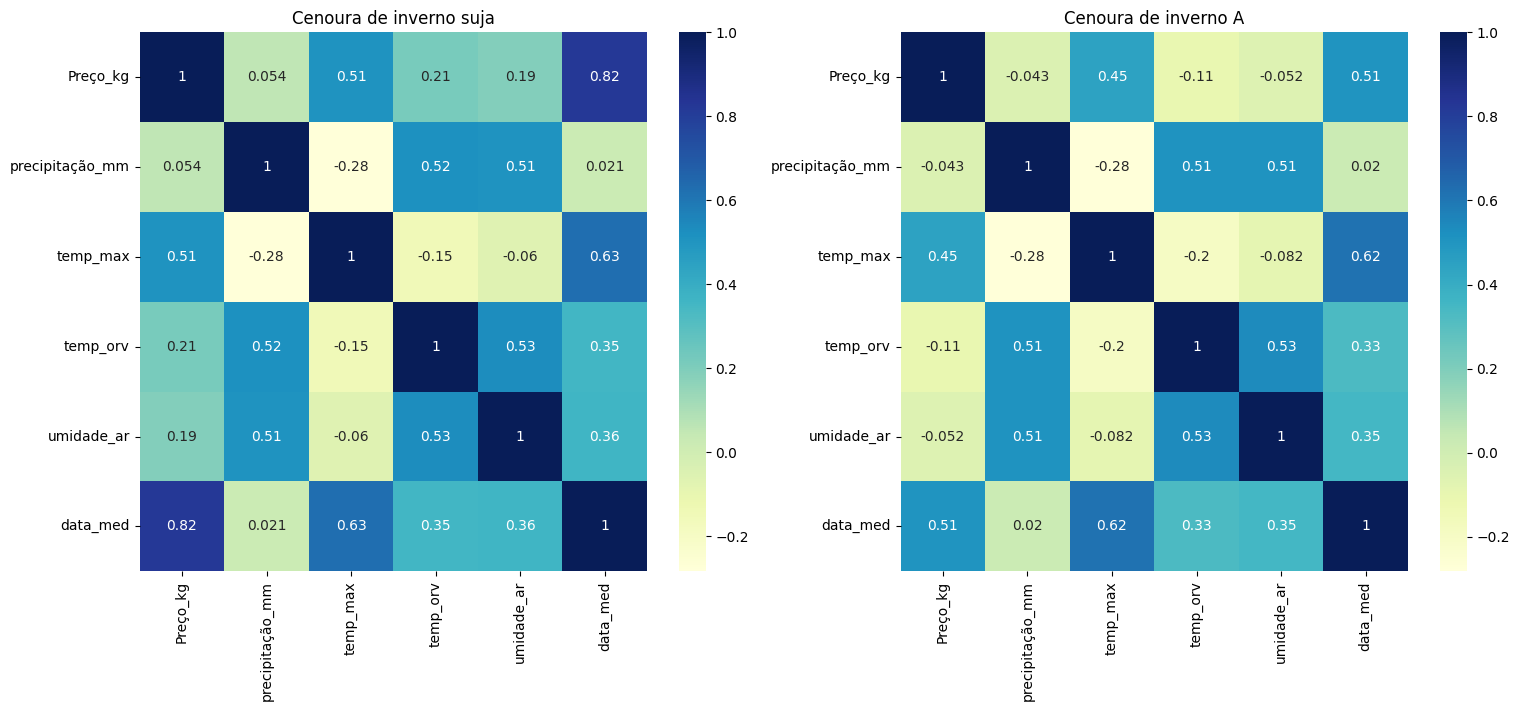

In [61]:
# plotando a correlação da cenoura inverno suja e cenoura inverno A
fig,ax = plt.subplots(ncols=2,figsize=(18,7))

sns.heatmap(isx.corr(), annot=True, cmap="YlGnBu", ax=ax[0])
ax[0].set_title('Cenoura de inverno suja')
sns.heatmap(iax.corr(), annot=True, cmap="YlGnBu", ax=ax[1])
ax[1].set_title('Cenoura de inverno A')

plt.show()

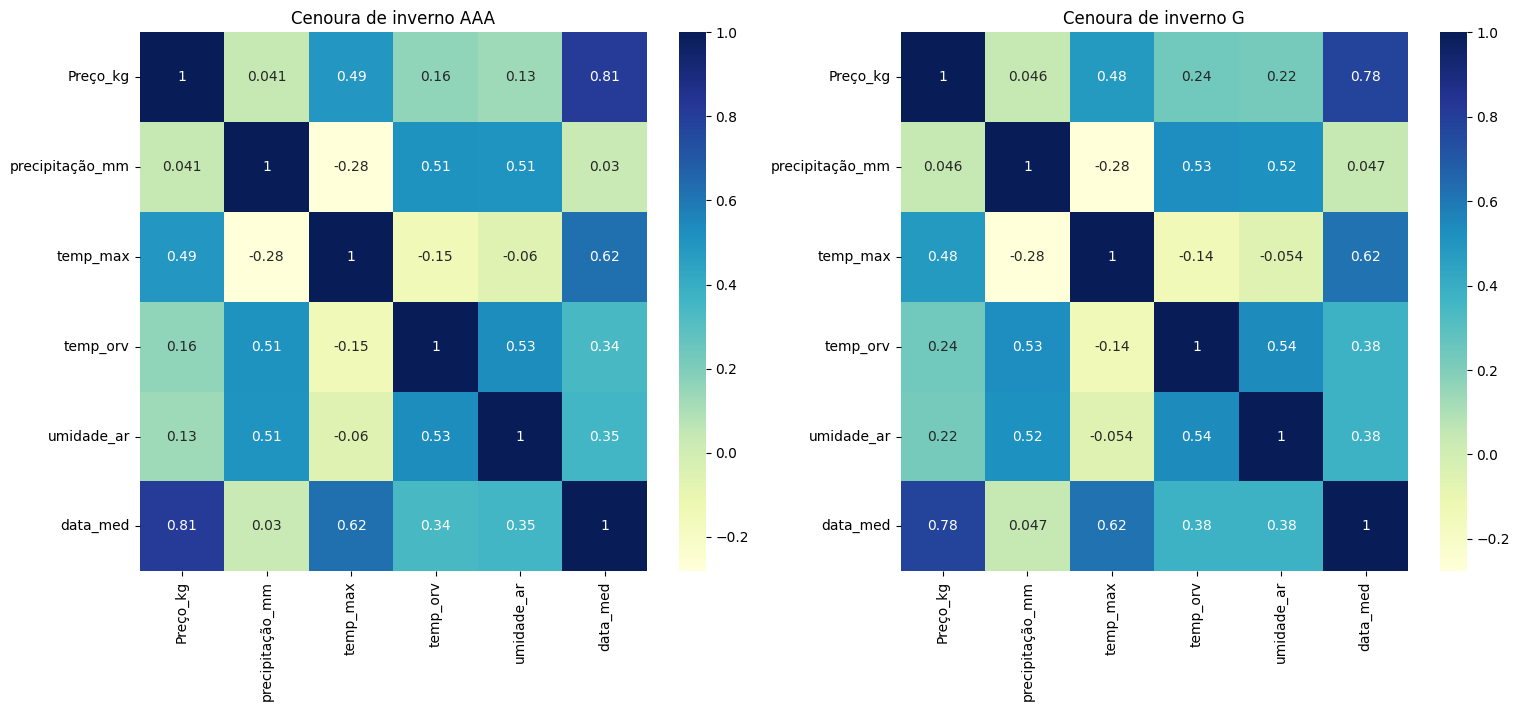

In [62]:
# plotando a correlação da cenoura inverno AAA e cenoura inverno G
fig,ax = plt.subplots(ncols=2,figsize=(18,7))

sns.heatmap(iaaax.corr(), annot=True, cmap="YlGnBu", ax=ax[0])
ax[0].set_title('Cenoura de inverno AAA')
sns.heatmap(igx.corr(), annot=True, cmap="YlGnBu", ax=ax[1])
ax[1].set_title('Cenoura de inverno G')

plt.show()

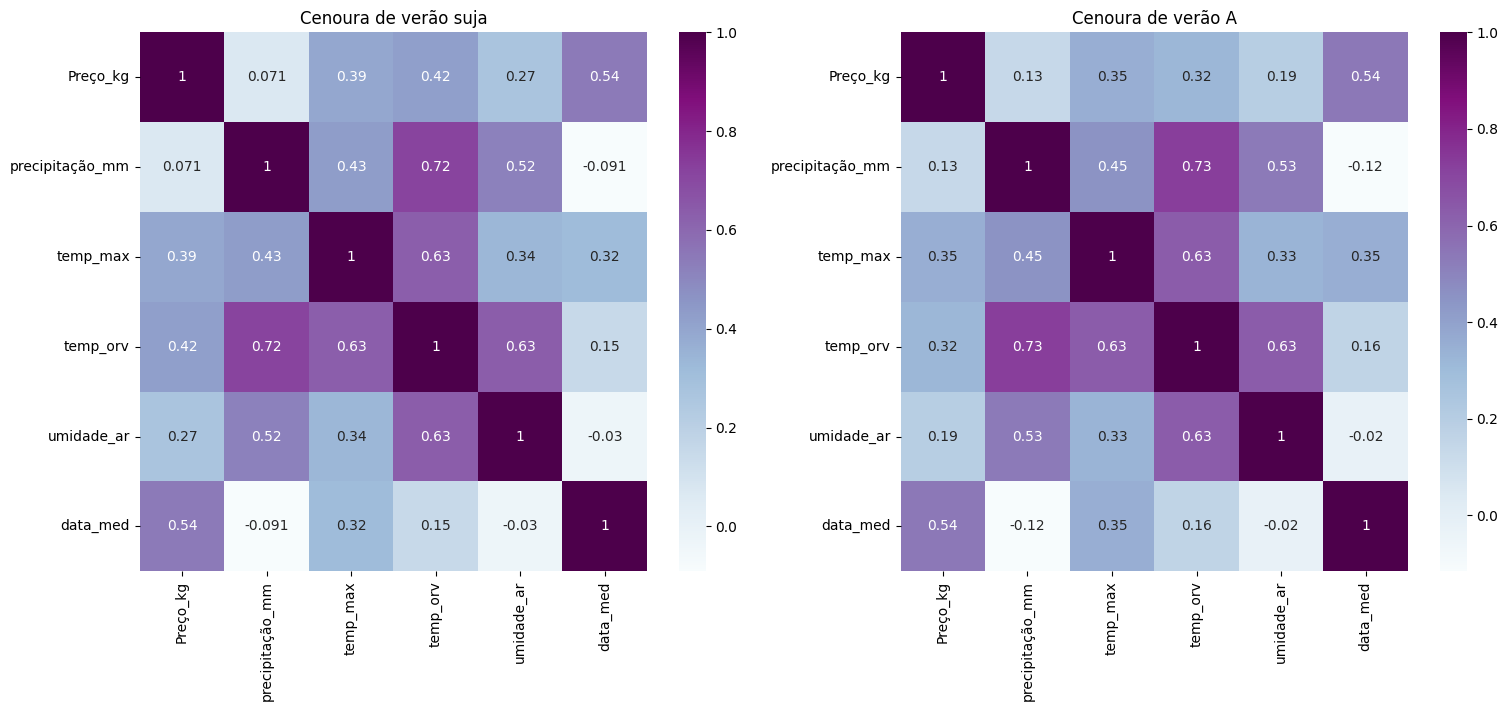

In [63]:
# plotando a correlação da cenoura verão suja e cenoura verão A
fig,ax = plt.subplots(ncols=2,figsize=(18,7))

sns.heatmap(vsx.corr(), annot=True, cmap="BuPu", ax=ax[0])
ax[0].set_title('Cenoura de verão suja')
sns.heatmap(vax.corr(), annot=True, cmap="BuPu", ax=ax[1])
ax[1].set_title('Cenoura de verão A')

plt.show()

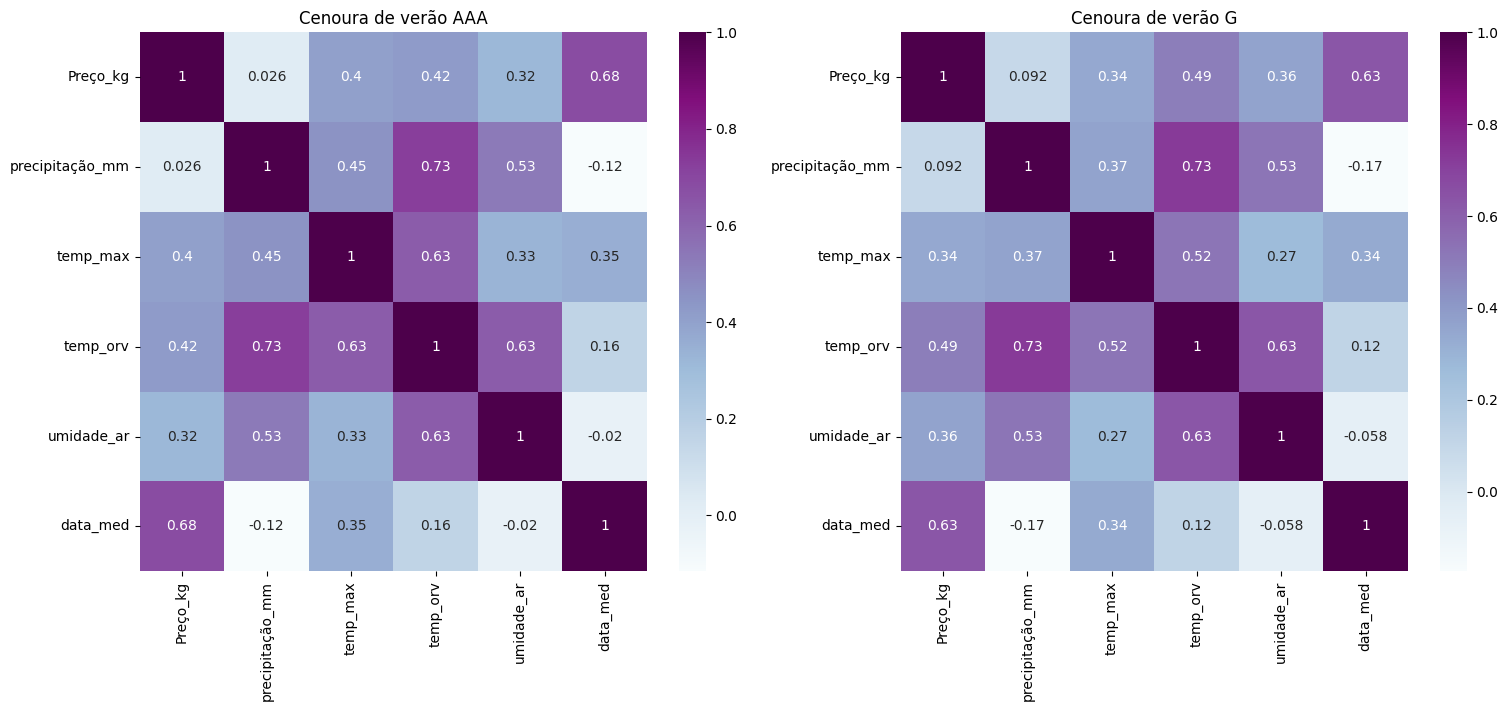

In [64]:
# plotando a correlação da cenoura verão AAA e cenoura verão G
fig,ax = plt.subplots(ncols=2,figsize=(18,7))

sns.heatmap(vaaax.corr(), annot=True, cmap="BuPu", ax=ax[0])
ax[0].set_title('Cenoura de verão AAA')
sns.heatmap(vgx.corr(), annot=True, cmap="BuPu", ax=ax[1])
ax[1].set_title('Cenoura de verão G')

plt.show()

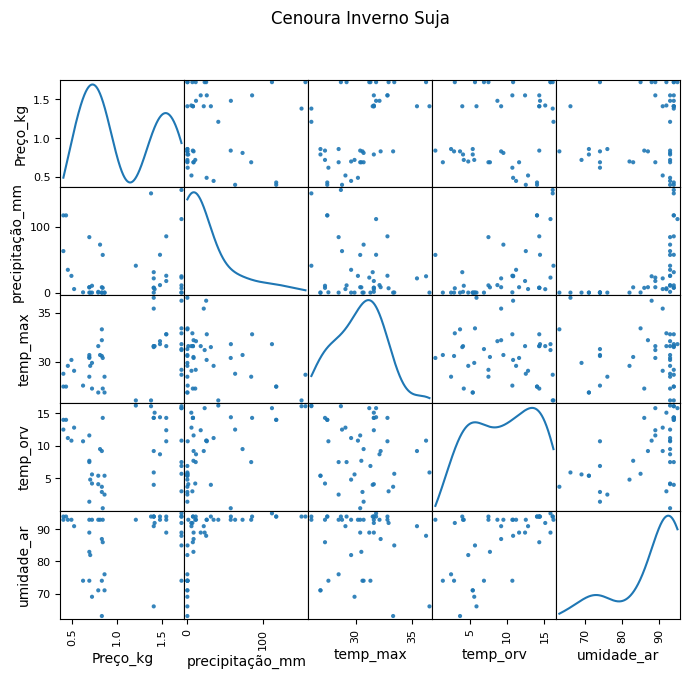

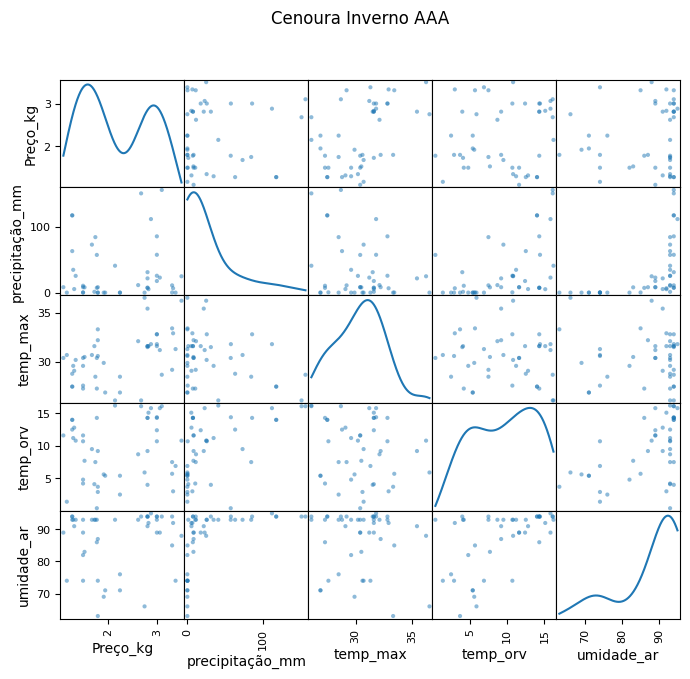

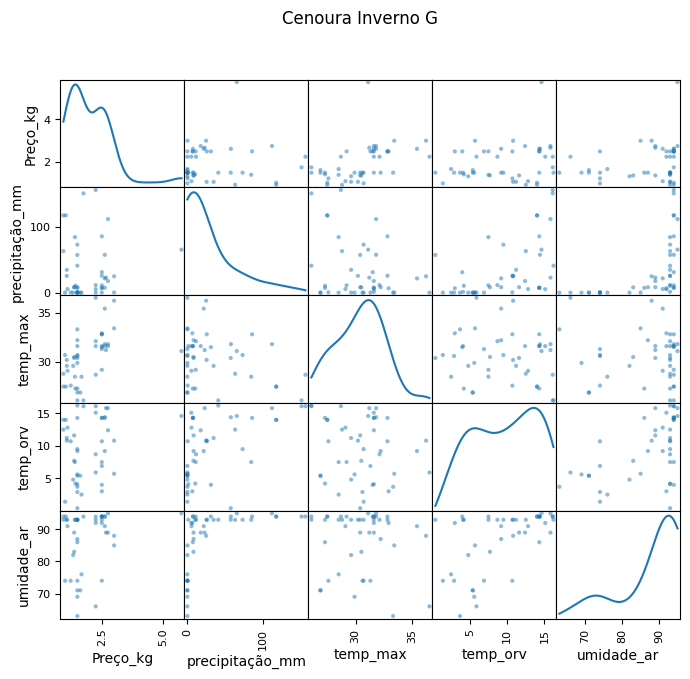

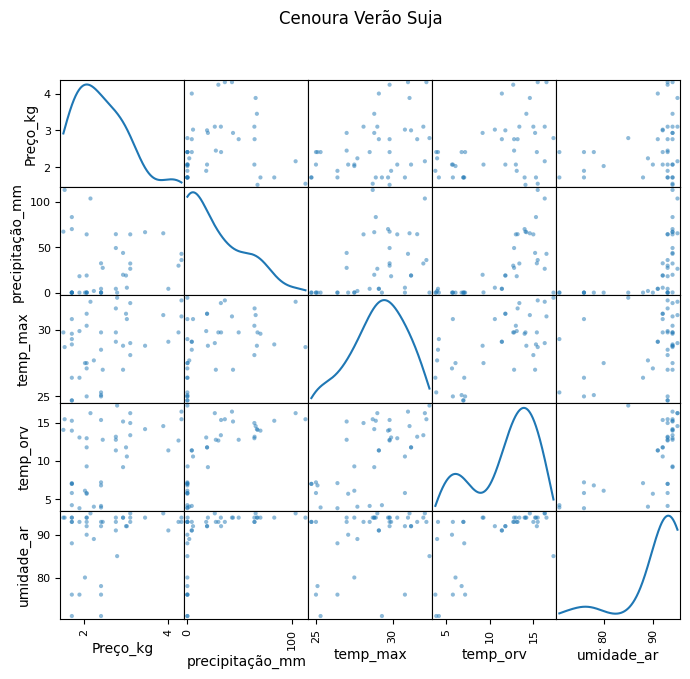

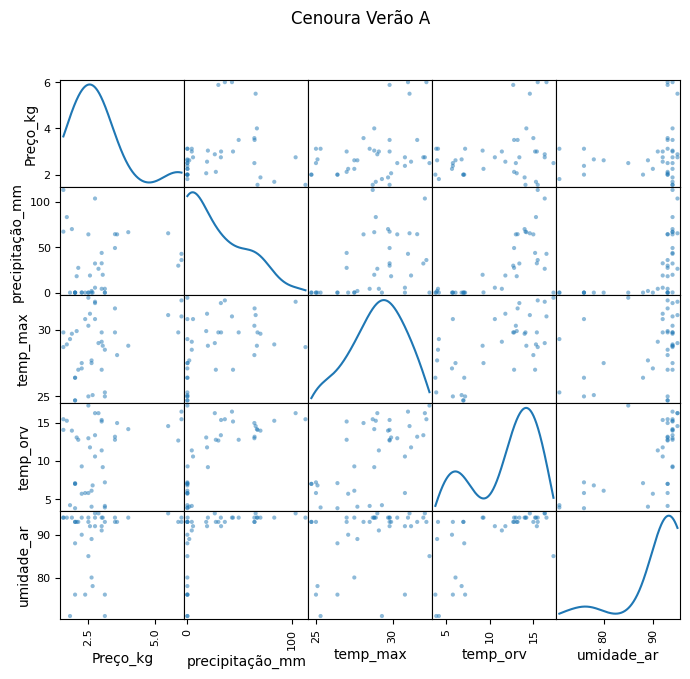

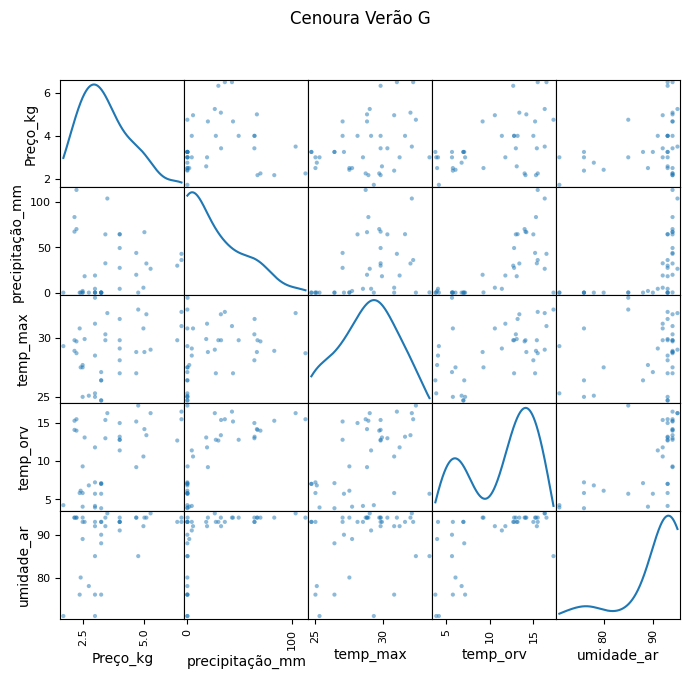

In [65]:
# verifica a melhor distribuição em preço e precipitação
pd.plotting.scatter_matrix(isx, alpha=0.9, figsize=(8, 7), diagonal='kde'); 
plt.suptitle('Cenoura Inverno Suja')
plt.show()


"""pd.plotting.scatter_matrix(iax, alpha=0.5, figsize=(8, 7),diagonal='kde'); 
plt.suptitle('Cenoura Inverno A')
plt.show()
"""

pd.plotting.scatter_matrix(iaaax, alpha=0.5, figsize=(8, 7),diagonal='kde'); 
plt.suptitle('Cenoura Inverno AAA')
plt.show()

pd.plotting.scatter_matrix(igx, alpha=0.5, figsize=(8, 7),diagonal='kde'); 
plt.suptitle('Cenoura Inverno G')
plt.show()

pd.plotting.scatter_matrix(vsx, alpha=0.5, figsize=(8, 7),diagonal='kde'); 
plt.suptitle('Cenoura Verão Suja')
plt.show()

pd.plotting.scatter_matrix(vax, alpha=0.5, figsize=(8, 7),diagonal='kde'); 
plt.suptitle('Cenoura Verão A')
plt.show()


"""pd.plotting.scatter_matrix(vaaax, alpha=0.5, figsize=(8, 7),diagonal='kde'); 
plt.suptitle('Cenoura Verão AAA')
plt.show()
"""

pd.plotting.scatter_matrix(vgx, alpha=0.5, figsize=(8, 7),diagonal='kde'); 
plt.suptitle('Cenoura Verão G')
plt.show()

Após a análise das matrizes de dispersão e verificando a distribuição, optou-se por utilizar os dados de cenoura 
verão AAA e os dados de cenoura inverno A para prosseguir os estudos, por apresentarem uma correlação razoável e a melhor 
distribuição mostrada pelo cone do sino. Vamos trabalhar com a temperatura e preço, já que a precipitação ficou com
uma correlação muito baixa em relação ao preço, além de sua distribuição ficar bastante assimétrica para a esquerda,
a temp_orv e umidade_ar está com a distribuição assimétrica para a direita, então trabalharemos somente com a temperatura
e o preço.

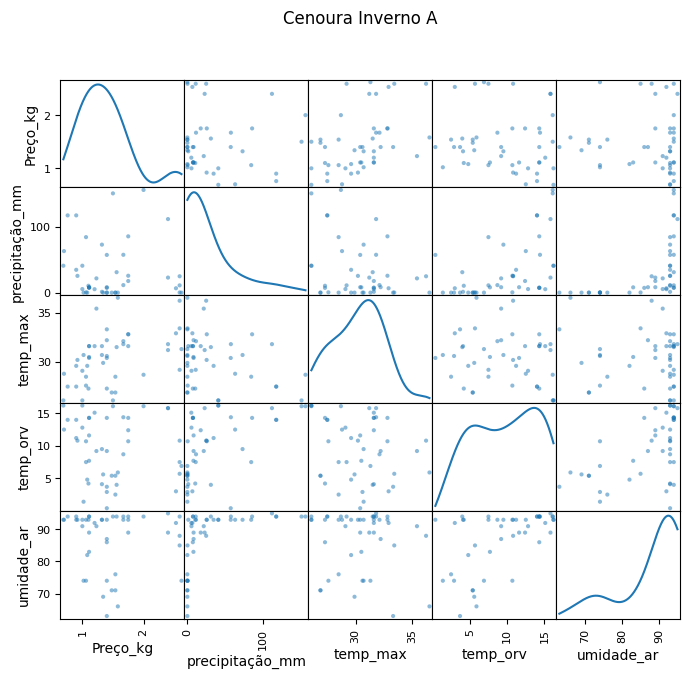

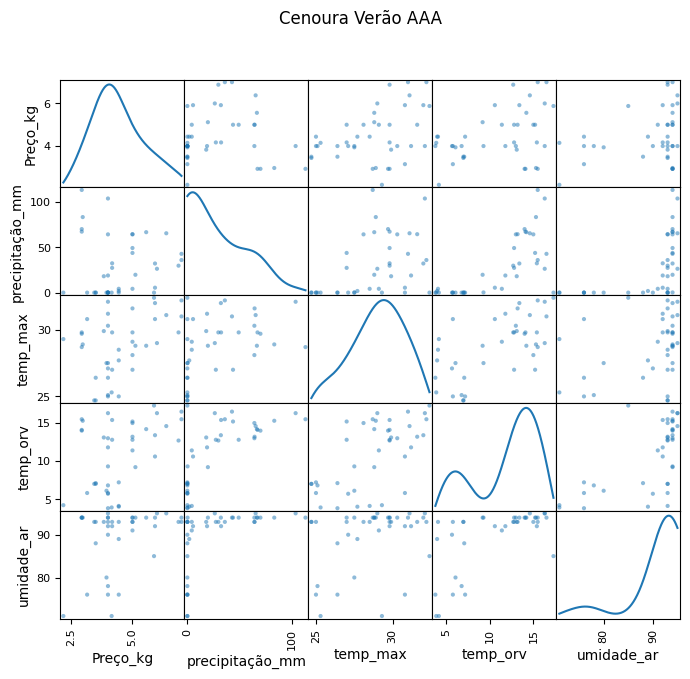

In [66]:
# o estudo seguirá com esses dois tipos de cenouras inverno A e verão AAA
pd.plotting.scatter_matrix(iax, alpha=0.5, figsize=(8, 7),diagonal='kde'); 
plt.suptitle('Cenoura Inverno A')
plt.show()

pd.plotting.scatter_matrix(vaaax, alpha=0.5, figsize=(8, 7),diagonal='kde'); 
plt.suptitle('Cenoura Verão AAA')
plt.show()

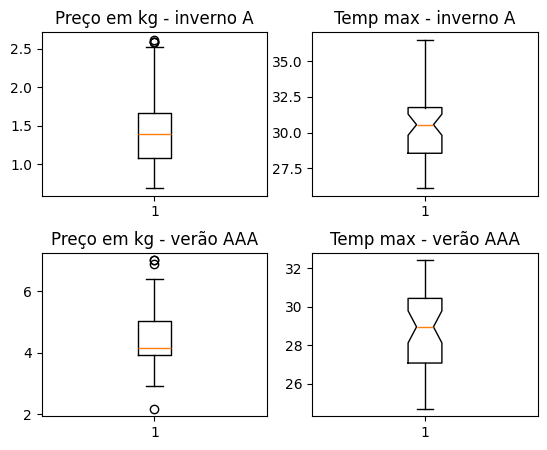

In [67]:
# verifica outliers de preço e temp_max para cenoura inverno A e cenoura verão AAA
fig, axs = plt.subplots(2, 2)

# linha 0 coluna 0
axs[0, 0].boxplot(iax.Preço_kg)
axs[0, 0].set_title('Preço em kg - inverno A')

# linha 0 coluna 1
axs[0, 1].boxplot(iax.temp_max, 1)
axs[0, 1].set_title('Temp max - inverno A')

# linha 1 coluna 0
axs[1, 0].boxplot(vaaax.Preço_kg)
axs[1, 0].set_title('Preço em kg - verão AAA')

# linha 1 coluna 1
axs[1, 1].boxplot(vaaax.temp_max, 1)
axs[1, 1].set_title('Temp max - verão AAA')

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)

plt.show()

In [68]:
# identifica os outliers de preço em verão AAA e inverno A e verifica a necessidade de mantê-los
print('CENOURA INVERNO A - maiores valores')
print(iax.sort_values("Preço_kg", ascending=False).head(6)[['Preço_kg']])
print(' ')
print('CENOURA VERÃO AAA - maiores valores')
print(vaaax.sort_values(by=["Preço_kg"], ascending=False)[['Preço_kg']].head(6))
print(' ')
print('CENOURA VERÃO AAA - menores valores')
print(vaaax.sort_values(by=["Preço_kg"], ascending=False)[['Preço_kg']].tail(6))

CENOURA INVERNO A - maiores valores
       Preço_kg
11060      2.62
11276      2.59
11179      2.59
10868      2.59
10964      2.53
11468      2.40
 
CENOURA VERÃO AAA - maiores valores
       Preço_kg
12837      7.00
12956      7.00
13053      6.88
12742      6.38
13341      6.00
13437      5.92
 
CENOURA VERÃO AAA - menores valores
       Preço_kg
10773      3.15
8189       2.97
7997       2.93
8093       2.93
7901       2.93
10677      2.18


In [69]:
print(iax.shape)
print(vaaax.shape)

(46, 6)
(40, 6)


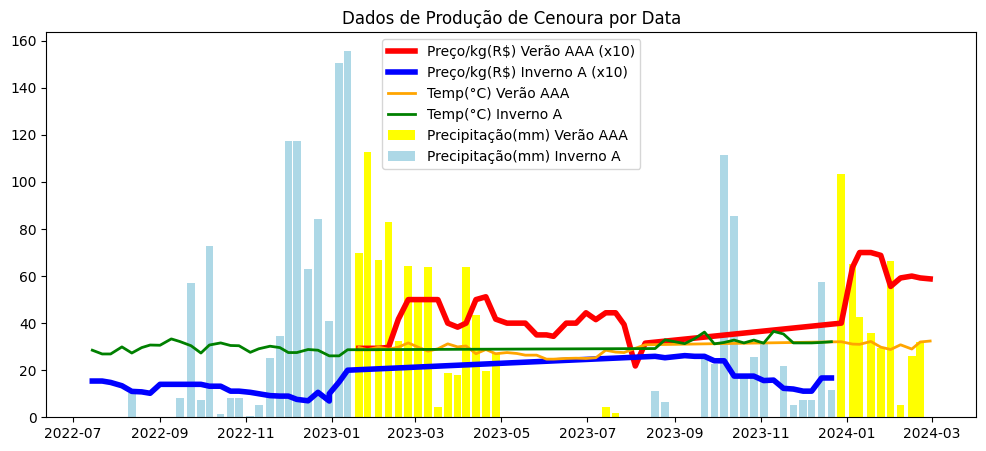

In [70]:
# plot da cotação do preço da cenoura de verão AAA e inverno A com a variação da temperatura x10 para melhor comparar
# a variação entre o Preço e a Temperatura
fig,ax = plt.subplots(ncols=1,figsize=(12,5))

plt.plot(vaaax.data_med, vaaax.Preço_kg * 10, label = "Preço/kg(R$) Verão AAA (x10)", linewidth=4, color='red') 
plt.plot(iax.data_med, iax.Preço_kg * 10, label = "Preço/kg(R$) Inverno A (x10)", linewidth=4, color='blue') 
plt.plot(vaaax.data_med, vaaax.temp_max, label = "Temp(°C) Verão AAA", linewidth=2, color='orange')  
plt.plot(iax.data_med, iax.temp_max, label = "Temp(°C) Inverno A", linewidth=2, color='green') 

plt.bar(vaaax.data_med, vaaax.precipitação_mm, color ='yellow', width = 5.4, label="Precipitação(mm) Verão AAA") 
plt.bar(iax.data_med, iax.precipitação_mm, color ='lightblue', width = 5.4, label="Precipitação(mm) Inverno A")

plt.title('Dados de Produção de Cenoura por Data')
plt.legend() 
plt.show()